In [2]:
import fastbox as fb
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.optimize import newton
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import psutil
import os

print(u"Current process's memory usage：%.4f GB" % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )

info = psutil.virtual_memory()
print(u'Total computer memory：%.4f GB' % (info.total / 1024 ** 3) )
print(u'Current percentage of total memory used：',info.percent)
print(u'Number of CPUs：',psutil.cpu_count())

Current process's memory usage：0.2819 GB
Total computer memory：63.9449 GB
Current percentage of total memory used： 15.3
Number of CPUs： 8


$forward$: Spot price    
$mat$ : The total time of the option contract    
$r$: risk-free rate     
$sigma:$ The volatility of spot prices

In [4]:
forward_price=fb.data.futures.daily(instrumentid = 'CU2110',from_date = '2021-01-01',to_date = '2021-12-31')
option_price = fb.data.futuresoptions.daily(instrumentid = 'CU2110',from_date = '2021-04-16',to_date = '2021-04-16')

In [5]:
option_price

close    open    high     low  \
date       maturity   call_put strike                                     
2021-04-16 2021-09-24 C        43000.0  25722.0     0.0     0.0     0.0   
                               44000.0  24730.0     0.0     0.0     0.0   
                               45000.0  23742.0     0.0     0.0     0.0   
                               46000.0  22754.0     0.0     0.0     0.0   
                               47000.0  21770.0     0.0     0.0     0.0   
...                                         ...     ...     ...     ...   
                      P        70000.0   4224.0  4224.0  4224.0  4224.0   
                               71000.0   4846.0  4846.0  4846.0  4846.0   
                               72000.0   6200.0     0.0     0.0     0.0   
                               73000.0   6850.0     0.0     0.0     0.0   
                               74000.0   7530.0     0.0     0.0     0.0   

                                         settle     vol   amount   oi  \
date       maturity   call_put strike                                   
2021-04-16 2021-09-24 C        43000.0  25722.0  0.0000      0.0  0.0   
                               44000.0  24730.0  0.0000      0.0  3.0   
                               45000.0  23742.0  0.0000      0.0  1.0   
                               46000.0  22754.0  0.0000      0.0  0.0   
                               47000.0  21770.0  0.0000      0.0  0.0   
...                                         ...     ...      ...  ...   
                      P        70000.0   4996.0  0.0001  21120.0  2.0   
                               71000.0   5582.0  0.0001  24230.0  2.0   
                               72000.0   6200.0  0.0000      0.0  0.0   
                               73000.0   6850.0  0.0000      0.0  1.0   
                               74000.0   7530.0  0.0000      0.0  1.0   

                                        list_date  instrumentid  
date       maturity   call_put strike                            
2021-04-16 2021-09-24 C        43000.0 2020-10-16  CU2110C43000  
                               44000.0 2020-10-16  CU2110C44000  
                               45000.0 2020-10-16  CU2110C45000  
                               46000.0 2020-10-16  CU2110C46000  
                               47000.0 2020-10-16  CU2110C47000  
...                                           ...           ...  
                      P        70000.0 2021-02-23  CU2110P70000  
                               71000.0 2021-02-23  CU2110P71000  
                               72000.0 2021-02-23  CU2110P72000  
                               73000.0 2021-02-23  CU2110P73000  
                               74000.0 2021-02-26  CU2110P74000  

[64 rows x 10 columns]

In [71]:
forward=forward_price.loc['2021-04-16','close'] # spot price
mat=(option_price.index.get_level_values('maturity')[0]-option_price.index.get_level_values('date')[0]).days
r=0.03

In [72]:
N = norm.cdf
def BS(forward, strike, mat, r, sigma, flag):
    """
    This function returns the BS price for an option on futures Flag = P or C
    We assume that sigma is yearly and r is yearly. mat is the number of days to maturity so tau = mat / 360
    """
    sign = 1
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "P":
        sign = -1
    std_dev = sigma * np.sqrt(tau)

    d1 = np.log(discount*forward/strike) / std_dev + 0.5 * std_dev
    d2 = d1 - std_dev
    result = discount * sign * (forward * N(sign * d1) - strike * N(sign * d2))
    return result

# now for the implied volatility
# remember the put call parity
# BS(call) - BS(put) = discount * (forward - K)
# so if the strike is very high (for the put out of the money) then BS(put) is close to 0. then the corresponding call is equal to BS(call) = disount * (forward - K) - BS(put) and you search the implied vol for this call and strike
# the decision for in/out of the money is if K>forward then call if K<forward then put

def IV(forward, strike, mat, r, price, flag):
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "C" and strike < forward:
        flag = "P"
        price = price - discount *(forward - strike)
    elif flag == "P" and strike >= forward:
        flag = "C"
        price = discount *(forward - strike) + price
    
    def root_func(x):
        return BS(forward, strike, mat, r, x, flag) - price
    sigma = newton(root_func, 0.2)
    return sigma

In [73]:
votility_df = pd.DataFrame() # Recording the results of calculations
strike_price = []
votility_BS = []
flags = []
for index in option_price.index:
    try:
        flag=index[2]
        strike=index[3]#strike price
        price=option_price.loc[index,'close']#Option price
        votility=IV(forward, strike, mat, r, price, flag)
        strike_price.append(strike)
        votility_BS.append(votility)
        flags.append(flag)
    except:
        print(index)
votility_df['strike_price'] = strike_price
votility_df['votility_BS'] = votility_BS
votility_df['flags'] = flags

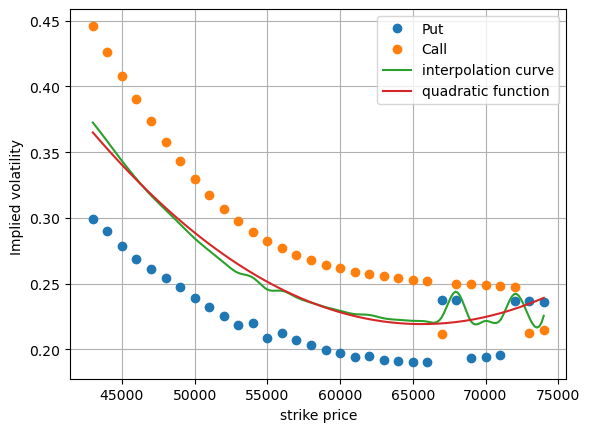

In [74]:
# The implied volatilities corresponding to the same strike values are averaged
votility_df_new=votility_df.groupby(votility_df['strike_price'], as_index=False).mean()
f = interp1d(votility_df_new['strike_price'], votility_df_new['votility_BS'], kind='cubic')  # cubic spline interpolation
strike_price_new_1 = np.linspace(votility_df_new['strike_price'].min(), votility_df_new['strike_price'].max(), 200)
votility_BS_new_1 = f(strike_price_new_1)

# quadratic function fitting
y=lambda x, a, b, c: a*x**2+b*x+c 
popt, pcov=curve_fit(y, strike_price, votility_BS) 
strike_price_new_2 = np.linspace(votility_df_new['strike_price'].min(), votility_df_new['strike_price'].max(), 200)
votility_BS_new_2 = y(strike_price_new_2, *popt)

plt.plot(votility_df[votility_df['flags']=='P']['strike_price'], votility_df[votility_df['flags']=='P']['votility_BS'], 'o', label='Put')
plt.plot(votility_df[votility_df['flags']=='C']['strike_price'], votility_df[votility_df['flags']=='C']['votility_BS'], 'o', label='Call')
plt.plot(strike_price_new_1, votility_BS_new_1, '-', label='interpolation curve')
plt.plot(strike_price_new_2, votility_BS_new_2, '-', label='quadratic function')
plt.xlabel('strike price')
plt.ylabel('Implied volatility ')
plt.grid(True)  
plt.legend()
plt.show()